## Generate a heatmap of a tv series episodes

In [1]:
# Libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Input show title to find the imdb id

#Variables
show = 'Doctor Who'
url_search = 'https://www.imdb.com/find?q='

# Set up Dataframe to create Heatmap
df = pd.DataFrame(columns=['show','season','episode','rating'])
df = df.astype({'show':'str','season':'int','episode':'int','rating':'float'})

# Put the search term in the url_search     example: imdb.com/find?q=breaking+bad
for word in show.split():
    if url_search[-1] == '=':
        url_search = url_search + word
    else:
        url_search = url_search+'+'+word
#url_search

# Parse the get request
r_search = requests.get(url_search)
soup_search = BeautifulSoup(r_search.text, 'html.parser')
#soup_search

# Get the imdb_id
content_search = soup_search.find('tr', attrs={'class':'findResult odd'})
imdb_id = content_search.find('a')['href'].split('/')[2]
show = content_search.find_all('a')[1].text
print(show,imdb_id)

Doctor Who tt0436992


In [3]:
# Use the imdb id to find the latest season available
r_home = requests.get('https://www.imdb.com/title/'+imdb_id)
soup_home = BeautifulSoup(r_home.text, 'html.parser')
#soup_home

# find the latest season available
content_home = soup_home.find('div', attrs = {'class': 'seasons-and-year-nav'})
max_season =  int(content_home.find('a').text)
max_season

12

In [4]:
# Find the ratings for episodes in each season
for current_season in range(1,max_season+1):
    r_season = requests.get('https://www.imdb.com/title/'+imdb_id+'/episodes?season='+str(current_season))
    soup_season = BeautifulSoup(r_season.text, 'html.parser')
    #soup_season
    episode = 1
    results = soup_season.find_all('span', attrs={'class':'ipl-rating-star__rating'})[::23]     #ratings occur in every 23rd item
    for rating in results:
        #print(current_season,episode,rating.text)
        df = df.append({'show':show,
                        'season':current_season,
                        'episode':episode,
                        'rating':float(rating.text)},
                        ignore_index=True)
        episode += 1

# Num of season and episodes determine size of plot
max_season = df.season.max()    
max_episode = df.episode.max()

df     

,show,season,episode,rating
0,Doctor Who,1,1,7.5
1,Doctor Who,1,2,7.6
2,Doctor Who,1,3,7.6
3,Doctor Who,1,4,7.0
4,Doctor Who,1,5,7.0
...,...,...,...,...
154,Doctor Who,12,6,5.2
155,Doctor Who,12,7,5.8
156,Doctor Who,12,8,7.2
157,Doctor Who,12,9,6.9


In [5]:
# Pivot Table
df_pivot = df.pivot(index='season',columns='episode',values='rating')
df_pivot

episode,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
season,,,,,,,,,,,,,,,
1,7.5,7.6,7.6,7.0,7.0,8.7,7.1,8.4,9.2,9.1,7.1,8.7,9.1,NaN,NaN
2,8.1,7.4,7.8,8.3,9.3,7.8,7.9,6.7,8.7,8.8,6.1,5.9,8.5,9.3,NaN
3,7.6,8.0,7.7,8.0,7.0,6.9,6.6,7.4,9.0,9.2,9.8,8.7,8.7,8.4,NaN
4,7.6,7.8,8.0,8.1,7.5,7.5,7.6,7.7,9.4,9.5,9.1,8.9,9.1,9.2,NaN
5,8.8,7.6,6.7,8.7,8.6,7.0,8.2,7.3,7.4,9.3,8.2,9.1,9.1,NaN,NaN
6,8.5,8.9,8.8,6.7,9.0,7.2,7.4,9.1,8.0,7.0,8.5,8.1,7.6,8.5,NaN
7,7.2,8.6,7.4,7.4,7.5,9.0,8.4,7.9,7.3,7.2,7.7,7.4,7.3,7.3,9.0
8,8.4,7.9,7.7,7.0,8.9,7.9,7.3,6.9,8.5,8.5,6.0,8.6,7.8,NaN,NaN
9,8.3,8.5,8.5,8.3,8.0,7.5,7.5,7.8,8.5,5.8,8.5,9.6,8.6,8.5,NaN


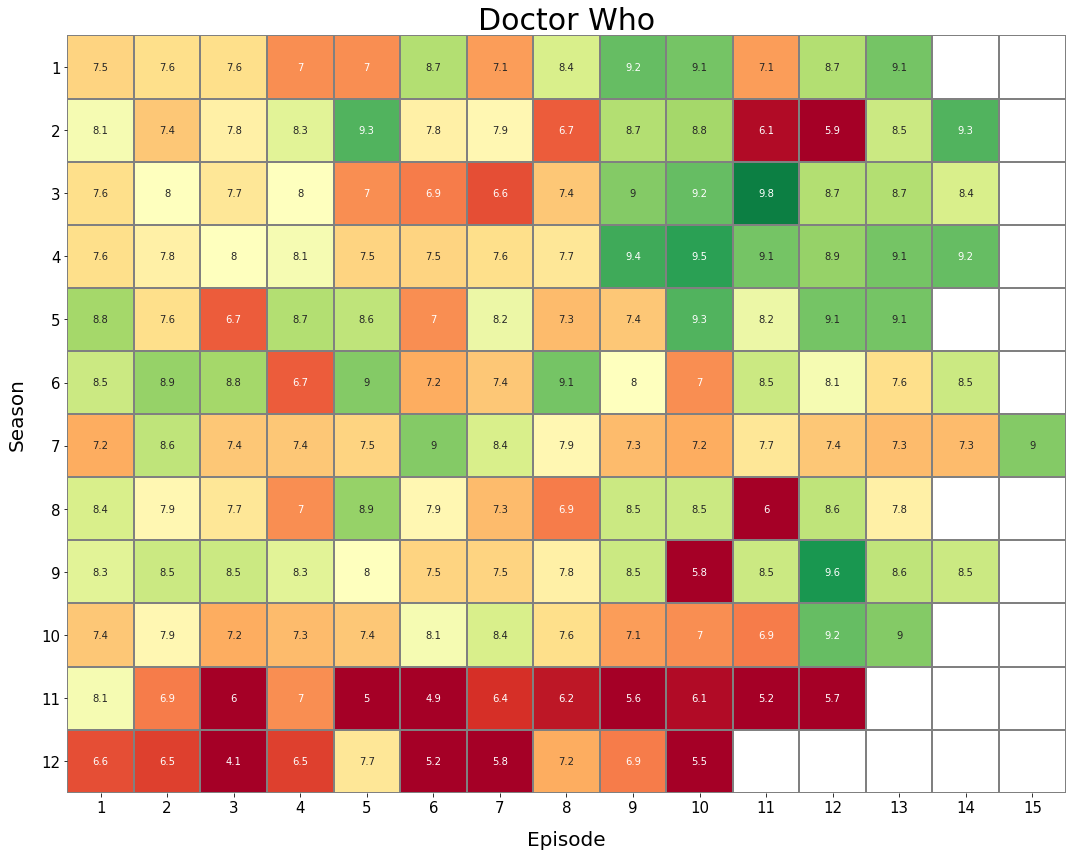

In [6]:
# Plot
f, ax = plt.subplots(figsize=(max_episode, max_season))
ax = sns.heatmap(df_pivot,vmin=6,vmax=10, annot=True,linewidths=1, cmap='RdYlGn', linecolor='gray', cbar=False)
ax.set_title(show,fontsize=30)
ax.set_xlabel('Episode',fontsize=20,labelpad=15)
ax.set_ylabel('Season',fontsize=20,labelpad=15)
ax.tick_params(labelsize=15)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(show+'.png')